In [64]:
from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer
from transformers import CLIPProcessor, CLIPModel, ViTImageProcessor, ViTModel
from datasets import load_dataset
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from io import BytesIO
from PIL import Image
import requests

In [40]:
device = torch.device("mps")

## `flickr50k` dataset exploration

- https://huggingface.co/datasets/nlphuji/flickr30k
- https://aclanthology.org/Q14-1006/

In [ ]:
dataset = load_dataset("nlphuji/flickr30k")

DatasetDict({
    test: Dataset({
        features: ['image', 'caption', 'sentids', 'split', 'img_id', 'filename'],
        num_rows: 31014
    })
})

In [38]:
train_set = dataset['test'].filter(lambda x: x['split'] == 'train')
val_set = dataset['test'].filter(lambda x: x['split'] == 'val')
test_set = dataset['test'].filter(lambda x: x['split'] == 'test')

print(f"Train set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")

Filter:   0%|          | 0/31014 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31014 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31014 [00:00<?, ? examples/s]

Train set size: 29000
Validation set size: 1014
Test set size: 1000


Image:


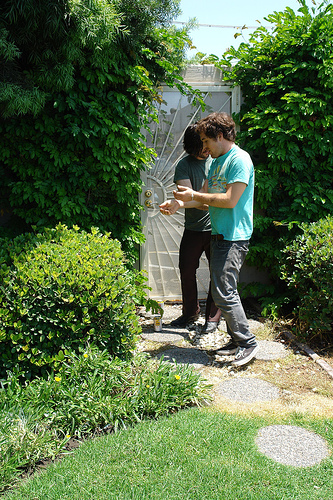

Captions:
- Two young guys with shaggy hair look at their hands while hanging out in the yard.
- Two young, White males are outside near many bushes.
- Two men in green shirts are standing in a yard.
- A man in a blue shirt standing in a garden.
- Two friends enjoy time spent together.


In [33]:
example = dataset['test'][0]
image = example["image"]  # PIL Image

print("Image:")
display(image)
print("Captions:")
for caption in example["caption"]:
    print(f"- {caption}")

In [ ]:
# Collect width and height for the first 50 images in the test split
widths = []
heights = []

for idx in range(50):
    img = dataset['test'][idx]['image']
    w, h = img.size  # PIL Image: (width, height)
    widths.append(w)
    heights.append(h)

widths = np.array(widths)
heights = np.array(heights)

print("Width stats:")
print(f"  min: {widths.min()}, max: {widths.max()}, mean: {widths.mean():.2f}, std: {widths.std():.2f}")

print("Height stats:")
print(f"  min: {heights.min()}, max: {heights.max()}, mean: {heights.mean():.2f}, std: {heights.std():.2f}")

Width stats:
  min: 330, max: 500, mean: 466.54, std: 61.17
Height stats:
  min: 230, max: 500, mean: 382.68, std: 69.60


## Qwen/Qwen3-0.6B-Base

In [ ]:
# 1. --- Model and Device Configuration ---
model_name = "Qwen/Qwen3-0.6B-Base"
device = "mps" # Explicitly set to Apple's Metal Performance Shaders

print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_name)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# 2. --- Load the model without quantization ---
# We have removed the BitsAndBytesConfig and quantization_config arguments.
# The model will load in bfloat16, which is natively supported on MPS.
print("Loading model in bfloat16...")
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16, # Use 16-bit precision
    device_map=device,          # Pin the model to the MPS device
    attn_implementation="sdpa"  # Still use PyTorch's native attention for best speed
)

print("\n--- Model Loaded Successfully on MPS ---\n")
print(model)

Loading tokenizer...
Loading model in bfloat16...

--- Model Loaded Successfully on MPS ---

Starting generation for prompt: 'Once upon a time, in a land filled with strange code and wondrous machines,'
--------------------------------------------------
 there lived a young inventor named Alex. Alex was known for his incredible inventions and his ability to turn any idea into a reality. One day, while tinkering with a mysterious device, Alex stumbled upon a hidden compartment inside the machine. Inside, he found a series of numbers and symbols that seemed to hold the key to unlocking a secret code.

Alex decided to take a closer look at the numbers and symbols. He noticed that they were arranged in a specific pattern, and he began to wonder if there

--------------------------------------------------
Generation finished.


In [ ]:
prompt = "Once upon a time, in a land filled with strange code and wondrous machines,"
model_inputs = tokenizer([prompt], return_tensors="pt").to(device)

print(f"Starting generation for prompt: '{prompt}'")
print("-" * 50)

streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

# Generate the output
output = model.generate(
    **model_inputs,
    max_new_tokens=100,
    streamer=streamer,
    pad_token_id=tokenizer.pad_token_id
)

print("\n" + "-" * 50)
print("Generation finished.")

## Qwen/Qwen2.5-VL-3B-Instruct

In [ ]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
from PIL import Image
import torch
import requests

# --- Configuration ---
model_name = "Qwen/Qwen2.5-VL-3B-Instruct"
device = "mps"

print(f"Loading processor for: {model_name}")
# The processor correctly bundles the tokenizer and image processor
processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)

print(f"Loading model: {model_name}")
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)

print("\n--- Model and Processor Loaded Successfully on MPS ---\n")
print(model)

Loading processor for: Qwen/Qwen2.5-VL-3B-Instruct
Loading model: Qwen/Qwen2.5-VL-3B-Instruct


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

Some parameters are on the meta device because they were offloaded to the disk.



--- Model and Processor Loaded Successfully on MPS ---



In [18]:
# The default range for the number of visual tokens per image in the model is 4-16384.
# You can set min_pixels and max_pixels according to your needs, such as a token range of 256-1280, to balance performance and cost.
# min_pixels = 256*28*28
# max_pixels = 1280*28*28
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels)

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg",
            },
            {"type": "text", "text": "Describe this image."},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("mps")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

RuntimeError: MPS backend out of memory (MPS allocated: 17.05 GB, other allocations: 4.27 MB, max allowed: 18.13 GB). Tried to allocate 6.10 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

## CLIP model

TODO Describe the model

In [43]:
# Load CLIP (ViT backbone)
clip_model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(clip_model_name)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)

clip_model.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [50]:
# TODO Estimate the model size

In [ ]:
clip_inputs = clip_processor(
    images=example["image"],
    return_tensors="pt"
).to(device)

with torch.no_grad():
    clip_outputs = clip_model.get_image_features(**clip_inputs)

print("CLIP image embedding:")
print("Size:", clip_outputs.shape)
print("Data:", clip_outputs[:, :20])

CLIP image embedding:
Size: torch.Size([1, 512])
Data: tensor([[-7.3105e-02,  3.5025e-01, -9.3551e-02, -4.5611e-01, -1.1746e-02,
          1.9847e-02,  5.3176e-01,  2.6167e-01,  1.3552e-02, -7.9294e-02,
          2.3512e-01, -2.5091e-01, -1.1292e+00,  1.5829e-01, -9.9726e-04,
         -5.9170e-02, -1.4245e+00,  1.8338e-01,  3.7977e-02,  1.7138e-01]],
       device='mps:0')


In [ ]:

clip_inputs = clip_processor(
    images=example["image"],
    return_tensors="pt"
).to(device)

with torch.no_grad():
    clip_outputs = clip_model.get_image_features(**clip_inputs)

print("CLIP image embedding:")
print("Size:", clip_outputs.shape)
print("Data:", clip_outputs[:, :20])



In [ ]:
texts = example["caption"]

# Tokenize text for CLIP
text_inputs = clip_processor(
    text=texts,
    return_tensors="pt",
    padding=True
)

# Move input tensors to the same device as the model
text_inputs = {k: v.to(device) for k, v in text_inputs.items()}

# Get text embeddings
with torch.no_grad():
    text_embeddings = clip_model.get_text_features(**text_inputs)

print("CLIP text embeddings:", text_embeddings.shape)

CLIP text embeddings: torch.Size([5, 512])


In [60]:
# Get another example
texts2 = dataset['test'][1]["caption"]

# Tokenize and embed texts for the second example
text_inputs2 = clip_processor(
    text=texts2,
    return_tensors="pt",
    padding=True
)
text_inputs2 = {k: v.to(device) for k, v in text_inputs2.items()}
with torch.no_grad():
    text_embeddings2 = clip_model.get_text_features(**text_inputs2)

# Normalize embeddings for cosine similarity
image_emb = clip_outputs / clip_outputs.norm(dim=-1, keepdim=True)
text_emb1 = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)
text_emb2 = text_embeddings2 / text_embeddings2.norm(dim=-1, keepdim=True)

# Compute similarities
sims1 = (image_emb @ text_emb1.T).squeeze().cpu().numpy()
sims2 = (image_emb @ text_emb2.T).squeeze().cpu().numpy()

# Prepare DataFrame
rows = []
for i, (txt, sim) in enumerate(zip(texts, sims1)):
    rows.append({'Source': 'Same image', 'Text': txt, 'Similarity': sim})
for i, (txt, sim) in enumerate(zip(texts2, sims2)):
    rows.append({'Source': 'Different image', 'Text': txt, 'Similarity': sim})

df = pd.DataFrame(rows)
with pd.option_context('display.max_colwidth', None):
    display(df)

,Source,Text,Similarity
0,Same image,Two young guys with shaggy hair look at their hands while hanging out in the yard.,0.326571
1,Same image,"Two young, White males are outside near many bushes.",0.310841
2,Same image,Two men in green shirts are standing in a yard.,0.328633
3,Same image,A man in a blue shirt standing in a garden.,0.298758
4,Same image,Two friends enjoy time spent together.,0.248078
5,Different image,Several men in hard hats are operating a giant pulley system.,0.194166
6,Different image,Workers look down from up above on a piece of equipment.,0.208850
7,Different image,Two men working on a machine wearing hard hats.,0.215243
8,Different image,Four men on top of a tall structure.,0.196123
9,Different image,Three men on a large rig.,0.203327


## ViT model

TODO Describe the model

In [48]:
# Load ViT
vit_model_name = "google/vit-base-patch16-224-in21k"
vit_model = ViTModel.from_pretrained(vit_model_name)
vit_processor = ViTImageProcessor.from_pretrained(vit_model_name)

vit_model.to(device)

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ViTOutput(
          (d

In [ ]:
vit_inputs = vit_processor(
    images=example["image"],
    return_tensors="pt"
).to(device)

with torch.no_grad():
    vit_outputs = vit_model(**vit_inputs)
    # CLS embedding: last_hidden_state[:, 0]
    cls_embedding = vit_outputs.last_hidden_state[:, 0]

print("ViT CLS embedding:")
print("Size:", cls_embedding.shape)
print("Data:", cls_embedding[:, :20])

ViT CLS embedding:
Size: torch.Size([1, 768])
Data: tensor([[-0.0505, -0.1959,  0.0742,  0.2311,  0.0227, -0.2766, -0.3676, -0.0301,
         -0.1230, -0.0262, -0.0926, -0.1874, -0.0153, -0.0125,  0.0515, -0.3613,
          0.1196, -0.2313,  0.2244,  0.0781]], device='mps:0')


## GPT2

In [65]:
# Small GPT-2 (124M params)
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [66]:
# Encode a prompt
prompt = "Once upon a time"
inputs = tokenizer(prompt, return_tensors="pt").to(device)

# Generate text
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=30,
        do_sample=True,
        top_k=50
    )

print("Generated:", tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated: Once upon a time they were only fighting under the cover of darkness, when one could see a large lake. The men and women in those days had little of the old
